In [1]:
# Double DQN
# https://arxiv.org/abs/1509.06461
# Double Q-learning was first introduced in 2010 by van Hasselt.

# Double Q-Learning
# https://papers.nips.cc/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html

In [2]:
import gym
import math
import random
import time
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

seed_value = 42
torch.manual_seed(seed_value)
random.seed(seed_value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


*** Episode 0 ***                       
Av.reward: [last 10]: 0.80, [last 100]: 0.08, [all]: 8.00                       
epsilon: 0.89, frames_total: 8
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 21.30, [last 100]: 2.21, [all]: 20.09                       
epsilon: 0.58, frames_total: 221
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 13.40, [last 100]: 3.55, [all]: 16.90                       
epsilon: 0.45, frames_total: 355
Elapsed time:  00:00:00

*** Episode 30 ***                       
Av.reward: [last 10]: 10.80, [last 100]: 4.63, [all]: 14.94                       
epsilon: 0.36, frames_total: 463
Elapsed time:  00:00:00

*** Episode 40 ***                       
Av.reward: [last 10]: 10.60, [last 100]: 5.69, [all]: 13.88                       
epsilon: 0.30, frames_total: 569
Elapsed time:  00:00:00

*** Episode 50 ***                       
Av.reward: [last 10]: 12.60, [last 100]: 6.95, 

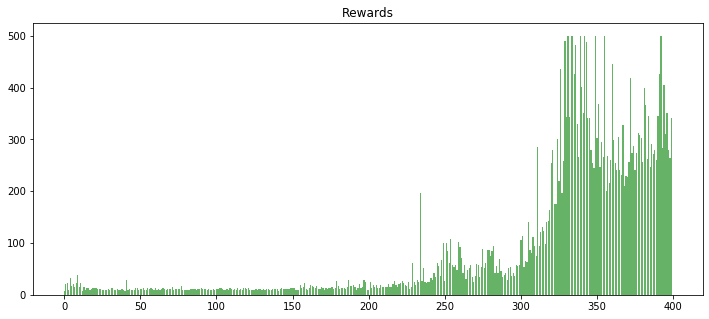

In [5]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v1')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.001
num_episodes = 400
gamma = 0.999

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

# stable vs faster convergence trade-off
update_target_frequency = 500

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval = 10
score_to_solve = 195


double_dqn = True

clip_error = True
####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2

    
# Memory for experience replay
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else: 
            self.memory[self.position] = transition
        self.position = (self.position + 1 ) % self.capacity
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
    def __len__(self):
        return len(self.memory)
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        # Update params target net
        self.update_target_counter = 0
        
        
    def select_action(self,state, epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = Tensor(done).to(device)

        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_index = torch.max(new_state_indexes, 1)[1]
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_index.unsqueeze(1)).squeeze(1)
            
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]

        
        target_value = reward + (1 - done) * gamma * max_new_state_values

        
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
#         print(self.nn(state).size())
#         print(action.unsqueeze(1).size())
#         print(predicted_value.size())
#         print(target_value.size())
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()

        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
            
        self.update_target_counter += 1
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()
